In [1]:
import jax
import jax.numpy as jnp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py as h5
import numpyro
import numpyro.distributions as dist
from numpyro.distributions.constraints import real

import pollux as plx
from pollux.models.transforms import LinearTransform

from process_rvs import *

In [2]:
jax.config.update("jax_enable_x64", True)

In [3]:
df = pd.read_pickle('/Users/honeyeah/Codes/LuxProject/pollux/docs/haniyeh_codes/data/stars.pkl')

In [4]:
#df = df[(df['logg']>1.5) & (df['logg']<3.5)] # giants 
#df = df[df['logg']>4] # dwarfs
df = df.drop_duplicates(subset='source_id')

In [5]:
# let's do first 100 stars
df = df.head(100)
source_ids = df['source_id'].astype('int64').values

In [6]:
indices = np.array(df.index)

In [7]:
wl = np.linspace(846, 870, 2401) # nm
source_ids_ordered=[]
flux=[]
flux_err=[]
for index in indices:

	source_id_single = df["source_id"][index]
	flux_single,flux_err_single = process_spectra(wl,df["flux"][index],df["flux_error"][index])

	flux.append(flux_single)
	flux_err.append(flux_err_single)
	source_ids_ordered.append(source_id_single)

flux = np.array(flux)
flux_err = np.array(flux_err)
ivar = 1/flux_err**2

In [8]:
df = df.sort_values('source_id')

In [9]:
Teff = df['teff'].values
logg = df['logg'].values
fe_h = df['fe_h'].values
mg_h = df['mg_h'].values
label = np.vstack((Teff,logg,fe_h,mg_h)).T
label_names = ['Teff', 'logg', '[Fe/H]', '[Mg/H]']

e_Teff = df['e_teff'].values
e_logg = df['e_logg'].values
e_fe_h = df['e_fe_h'].values
e_mg_h = df['e_mg_h'].values
e_label = np.vstack((e_Teff,e_logg,e_fe_h,e_mg_h)).T

In [10]:
all_data = plx.data.PolluxData(
    flux=plx.data.OutputData(
        flux,
        err=flux_err,
        preprocessor=plx.data.ShiftScalePreprocessor.from_data(flux),
    ),
    label=plx.data.OutputData(
        label,
        err=e_label, 
        preprocessor=plx.data.ShiftScalePreprocessor.from_data(label),
    ),
)

preprocessed_data = all_data.preprocess()

In [11]:
n_stars = len(df)
n_flux = flux.shape[1]  # len(df)
n_labels = 4
print(f"{n_stars=}, {n_flux=}, {n_labels=}")

train_data = preprocessed_data[: n_stars // 2]
test_data = preprocessed_data[n_stars // 2 :]
test_data_unprocessed = all_data[n_stars // 2:]
print(len(train_data), len(test_data))

n_stars=100, n_flux=2401, n_labels=4
50 50


In [12]:
model = plx.LuxModel(latent_size=8)

print(all_data.keys())  # noqa: T201
model.register_output("label", LinearTransform(output_size=n_labels))
model.register_output("flux", LinearTransform(output_size=n_flux))

# no regularization
trans = LinearTransform(
    output_size=n_labels, #param_priors={"A": dist.ImproperUniform(real, (), ())}
)

rngs = jax.random.split(jax.random.PRNGKey(42), 3)

dict_keys(['flux', 'label'])


In [13]:
# For this demo, we'll generate outputs for 10 objects
latents = jax.random.normal(rngs[0], shape=(10, model.latent_size))
pars = {
    "label": {"A": jax.random.normal(rngs[1], shape=(n_labels, model.latent_size))},
    "flux": {"A": jax.random.normal(rngs[2], shape=(n_flux, model.latent_size))},
}
outputs = model.predict_outputs(latents, pars)
print(outputs["label"].shape, outputs["flux"].shape)
print(train_data["label"].data.shape, train_data["flux"].data.shape)

(10, 4) (10, 2401)
(50, 4) (50, 2401)


100%|██████████| 10000/10000 [00:05<00:00, 1673.10it/s, init loss: 1572379.8056, avg. loss [9501-10000]: 132671.2494]


{'latents': Array([[ 3.64321664e-01,  5.88353789e-01, -2.10423548e-01,
        -4.22304317e-01, -8.12072988e-02,  1.23053379e+00,
        -2.36446382e-01, -9.37477806e-01],
       [-1.70266287e+00, -8.37511632e-01, -2.30884002e+00,
         5.94226021e-01,  6.19639239e-02,  8.04937005e-01,
         8.97115732e-01, -8.89944724e-01],
       [-1.79607452e-03, -1.45774208e-01,  9.15517505e-01,
         1.89308188e+00,  8.90430253e-01, -2.76766781e-01,
         1.09543144e+00,  5.93669636e-01],
       [ 7.76915299e-01, -3.56061577e-01, -2.71741546e-01,
         6.61031951e-01, -5.02495012e-01,  1.40539393e-01,
         4.75878637e-01,  3.67423375e-01],
       [ 1.67567508e+00, -5.47437592e-01, -4.95115625e-01,
         5.18284129e-02,  1.27420161e-02,  1.00750366e+00,
         9.52631832e-02, -8.41562036e-01],
       [ 9.13425030e-01,  3.13919765e-01, -5.82912405e-01,
         7.43629058e-01,  2.24702659e-01,  1.22053522e+00,
        -1.43010981e-01, -1.16672254e-01],
       [-4.62180539e-0

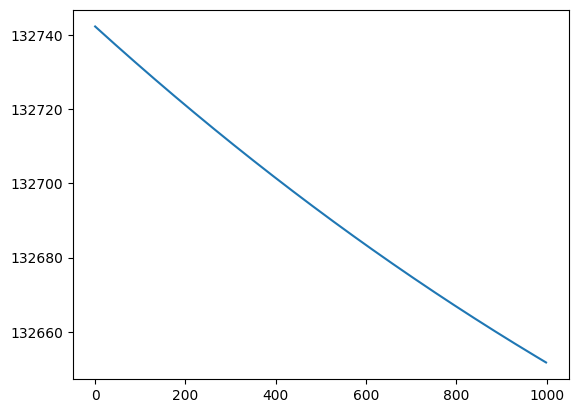

In [14]:
opt_pars, svi_results = model.optimize(
    train_data,
    rng_key=jax.random.PRNGKey(112358),
    optimizer=numpyro.optim.Adam(1e-3),
    num_steps=10_000,
    svi_run_kwargs={"progress_bar": True},
)
print(opt_pars)
print(svi_results.losses.block_until_ready())

plt.figure()
plt.plot(svi_results.losses[-1000:])
plt.show()

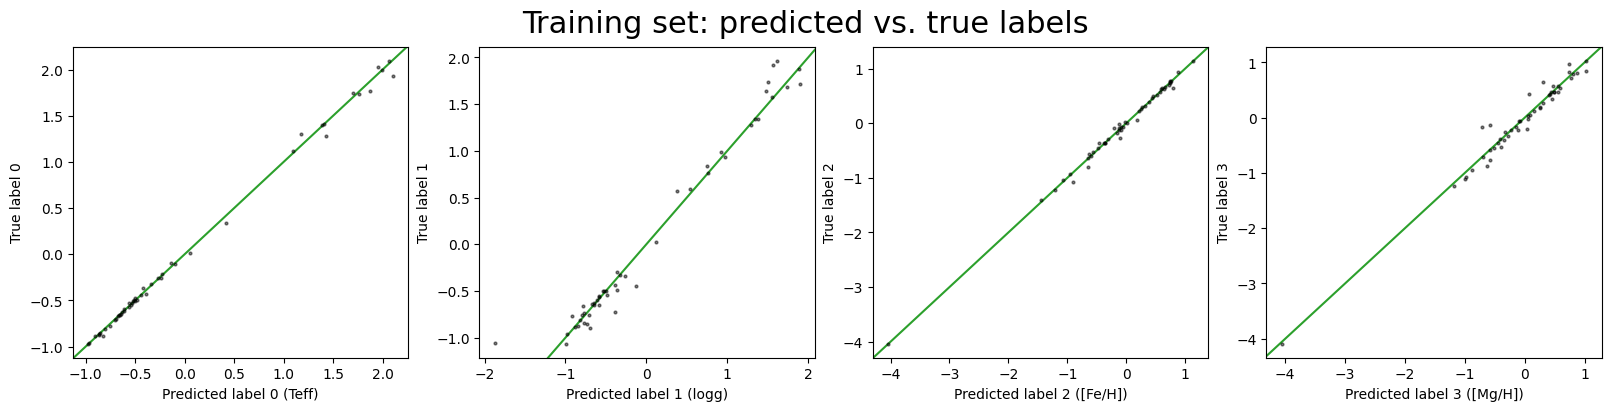

In [15]:
predict_train_values = model.predict_outputs(opt_pars["latents"], opt_pars)
pt_style = {"ls": "none", "ms": 2.0, "alpha": 0.5, "marker": "o", "color": "k"}

fig, axes = plt.subplots(1, n_labels, figsize=(4 * n_labels, 4), layout="constrained")
for i in range(n_labels):
    axes[i].plot(
        predict_train_values["label"][:, i], train_data["label"].data[:, i], **pt_style
    )
    axes[i].set(xlabel=f"Predicted label {i} ({label_names[i]})", ylabel=f"True label {i}")
    axes[i].axline([0, 0], slope=1, color="tab:green", zorder=-100)
_ = fig.suptitle("Training set: predicted vs. true labels", fontsize=22)
plt.show()


In [16]:
test_data

PolluxData({'flux': OutputData(
  data=f64[50,2401],
  err=f64[50,2401],
  preprocessor=ShiftScalePreprocessor(loc=f64[2401], scale=f64[2401]),
  processed=True
), 'label': OutputData(
  data=f32[50,4],
  err=f32[50,4],
  preprocessor=ShiftScalePreprocessor(loc=f32[4], scale=f32[4]),
  processed=True
)})

In [17]:
# Compare for test set:
fixed_pars = {
    "label": {"data": {"A": opt_pars["label"]["data"]["A"]}},
    "flux": {"data": {"A": opt_pars["flux"]["data"]["A"]}},
}
flux_only_data = plx.data.PolluxData(flux=test_data["flux"])



test_opt_pars, test_svi_results = model.optimize(
    flux_only_data,
    rng_key=jax.random.PRNGKey(12345),
    optimizer=numpyro.optim.Adam(1e-3),
    num_steps=10_000,
    names=["flux"],
    fixed_pars=fixed_pars,
)

test_svi_results.losses.block_until_ready()

100%|██████████| 10000/10000 [00:05<00:00, 1952.28it/s, init loss: 771709.4262, avg. loss [9501-10000]: 166954.2234]


Array([771709.42616764, 770083.8863832 , 768461.74218514, ...,
       166950.03532014, 166950.0211849 , 166950.00706505], dtype=float64)

In [18]:
flux_only_data

PolluxData({'flux': OutputData(
  data=f64[50,2401],
  err=f64[50,2401],
  preprocessor=ShiftScalePreprocessor(loc=f64[2401], scale=f64[2401]),
  processed=True
)})

In [19]:
predict_test_values = model.predict_outputs(test_opt_pars["latents"], fixed_pars)
predict_test_unprocessed = test_data.unprocess(predict_test_values)

In [20]:
test_data['label'].data

Array([[-9.2388874e-01, -8.4146684e-01,  6.4624530e-01,  4.1333118e-01],
       [-5.7908708e-01, -7.6408029e-01, -6.9167304e-01, -1.7475003e-01],
       [-1.0376314e+00, -9.9098796e-01,  6.7019939e-01,  5.5112553e-01],
       [ 5.6102747e-01,  9.2193782e-01,  8.6970693e-01,  9.8716933e-01],
       [-1.9017459e-01, -7.6286983e-01, -1.2243241e+00, -1.0901433e+00],
       [-9.5904189e-01, -5.9440953e-01,  3.7880856e-01,  4.8811340e-01],
       [-7.6987296e-01, -2.3581769e-02,  7.1110052e-01,  1.2207835e+00],
       [-7.1205354e-01, -5.4330021e-01,  8.3830571e-01,  7.0425534e-01],
       [-1.9330859e-01, -4.7524393e-01,  8.6240374e-02,  1.0974650e-01],
       [ 1.9471416e+00,  7.3885453e-01,  8.2547247e-01,  4.7993889e-01],
       [-2.6648009e-01, -9.6233922e-01, -1.8696846e+00, -1.2760575e+00],
       [-4.4828573e-01,  1.8512974e-02,  1.6606732e-01,  1.8943165e-01],
       [ 1.6891286e+00,  1.5715121e+00,  5.5308831e-01,  2.5138890e-02],
       [-9.6089852e-01, -5.4732853e-01, -1.5426418e

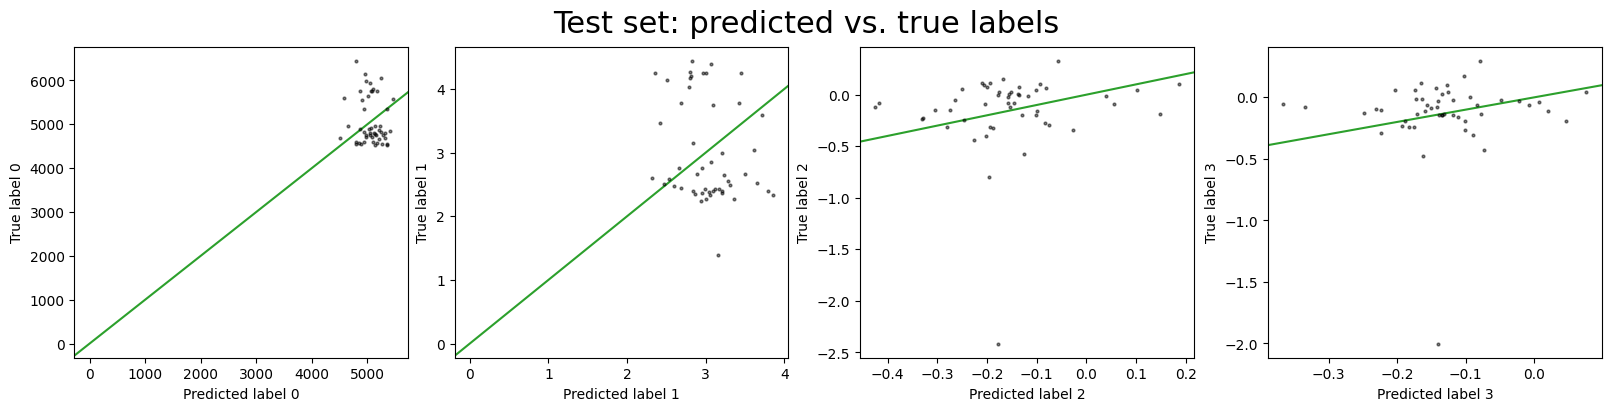

In [21]:
fig, axes = plt.subplots(1, n_labels, figsize=(4 * n_labels, 4), layout="constrained")
for i in range(n_labels):
    axes[i].plot(
        predict_test_unprocessed["label"].data[:, i], test_data_unprocessed["label"].data[:, i], **pt_style
    )
    axes[i].set(xlabel=f"Predicted label {i}", ylabel=f"True label {i}")
    axes[i].axline([0, 0], slope=1, color="tab:green", zorder=-100)
_ = fig.suptitle("Test set: predicted vs. true labels", fontsize=22)
plt.show()

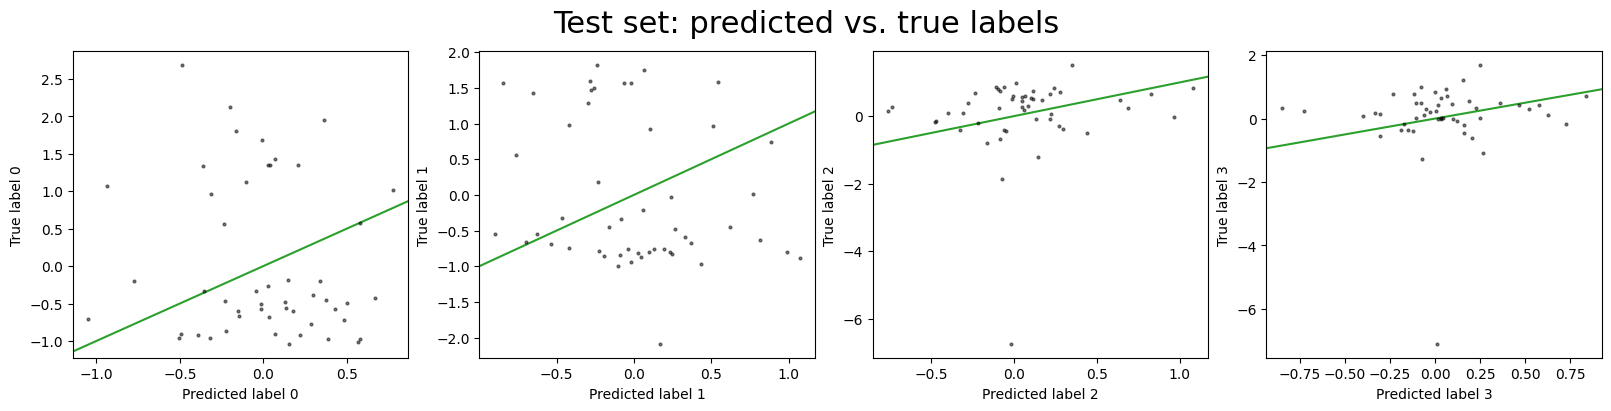

In [22]:
fig, axes = plt.subplots(1, n_labels, figsize=(4 * n_labels, 4), layout="constrained")
for i in range(n_labels):
    axes[i].plot(
        predict_test_values["label"][:, i], test_data["label"].data[:, i], **pt_style
    )
    axes[i].set(xlabel=f"Predicted label {i}", ylabel=f"True label {i}")
    axes[i].axline([0, 0], slope=1, color="tab:green", zorder=-100)
_ = fig.suptitle("Test set: predicted vs. true labels", fontsize=22)
plt.show()